In [1]:
import h5py
import numpy as np

image = h5py.File("../data/boat.mat","r")
image = image.get('imageOrig')
img = np.array(image)

In [2]:
import cv2
import numpy as np
import sys
import getopt
import operator

from numpy import zeros,zeros_like,array
from numpy import linspace,pi,sqrt,e,power,outer
from math import floor,ceil

def dnorm(x,mu,sigma):
    """
    Calculate pdf of the gaussian distribution with mean=mu
    and standard deviation = sigma
    input : x(point), mu(mean), sigma(standard deviation)
    ouptut :  pdf of the gaussian distribution at the point x
    """
    return 1 / (sqrt(2 * pi) * sigma) * e ** (-power((x - mu) / sigma, 2) / 2)

def gaussian_kernel(ksize,mu=0,sigma=1,verbose=False):
    """
    Create a normalized gaussian kernel with the given kernel size
    and standard deviation (sigma)
    inputs : ksize(for a ksizexksize gaussian filter),
             sigma(standard deviation, default=1)
             mu(mean of gaussian, default=0)
             verbose (to visualize the gaussian kernel)
    output : gaussian ksizexksize kernel filter
    """
    # create the 1-D gaussian kernel
    kernel_1D = linspace(-(ksize // 2), ksize // 2, ksize)
    for i in range(ksize):
        kernel_1D[i] = dnorm(kernel_1D[i], mu, sigma)

    # computers outer product of two 1-D gaussian kernels
    # to produce a 2D Gaussian Kernel
    kernel_2D = outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()


    return kernel_2D


def convolution(filename,input_image, kernel, average=False, verbose=False):
    """
    Calculates the convolution of input image with filter kernel
    after zero-padding with the required no. of pixels
    CAN BE USED WITH ANY KERNEL FILTER OF ANY SIZE
    input : image_file : input image file_path
            kernel : the filter kernel
            average : required only if the filter kernel is not normalized (default = False)
            verbose : to show and save the plots (default = False)
    output : the normalized output image after convolution
    Presently, the code works only for grayscale images, the color component will be added.
    """
    # READING THE INPUT IMAGE
    image = input_image.copy()
    name = filename.split("/")[-1].split(".")[0]

    # CONVERT THE RGB IMAGE TO GRAY
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        #print("Image Shape : {}".format(image.shape))
        pass

    #print("Kernel Shape : {}".format(kernel.shape))

    # EXTRACTING THE IMAGE AND KERNEL SHAPES AND INITIALIZING OUTPUT
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
    output = zeros(image.shape)

    # CREATING ZERO-PADDED IMAGE
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
    padded_image = zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    # CONVOLUTION OPERATION DONE HERE
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= (kernel_row * kernel_col)

    #print("Output Image size : {}".format(output.shape))
    # NORMALIZING THE OUTPUT IMAGE
    output = (output/np.max(output)) 

    return output

def gaussian_blur(filename,input_image, kernel_size, verbose=False):
    #sigma = sqrt(kernel_size)
    # this sigma is used by OpenCV implementation but explanation is not given
    sigma = 0.3*((kernel_size-1)*0.5 - 1) + 0.8
    print(sigma)
    #sigma = 2.0
    kernel = gaussian_kernel(kernel_size, sigma= sigma, verbose=verbose)
    return convolution(filename,input_image, kernel, average=False, verbose=False)

def findCorners(img, window_size_blur, sigma_weights, k, thresh):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    #Find x and y derivatives
    img = gaussian_blur("input.png",img,window_size_blur)
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]

    cornerList = []
    newImg = img.copy().astype(np.float64)
    #print(newImg.shape)
#     color_img = cv2.cvtColor(newImg,cv2.COLOR_GRAY2RGB)
    offset = int(window_size/2)

    #Loop through image and find our corners
    print("Finding Corners...")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            weight_kernel = gaussian_kernel(2*offset+1,sigma=sigma_weights)
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]*weight_kernel
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]*weight_kernel
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]*weight_kernel
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)

            #If corner response is over threshold, color the point and add to corner list
            if r > thresh:
                #print(x, y, r)
                cornerList.append([x, y, r])
                #plt.scatter(x,y,"r")
#                 color_img.itemset((y, x, 0), 0)
#                 color_img.itemset((y, x, 1), 0)
#                 color_img.itemset((y, x, 2), 255)
    return img, cornerList

In [ ]:
import matplotlib.pyplot as plt

window_size = 3
k = 0.24
thresh = 0.8
sigma_weights = 3.5

#print("Image Name: " + str(img_name[0]))
print("Window Size: " + str(window_size))
print("K Corner Response: " + str(k))
print("Corner Response Threshold:" + str(thresh))

#img = readImage(img_name[0])
if img is not None:
#     if len(img.shape) == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     if len(img.shape) == 4:
#         img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    print("Shape: " + str(img.shape))
    print("Size: " + str(img.size))
    print("Type: " + str(img.dtype))
#     print("Printing Original Image...")
#     print(img)
    finalImg, cornerList = findCorners(img, int(window_size),sigma_weights, float(k), int(thresh))
    plt.imshow(finalImg,cmap="gray",origin="lower")
    r,c = finalImg.shape
    #if finalImg is not None:
    #    cv2.imwrite("finalimage.png", finalImg)

    # Write top 100 corners to file
    cornerList.sort(key=operator.itemgetter(2))
    for i in cornerList:
        #k,j = np.unravel_index((i[0],i[1]), finalImg.shape)
        k,j,l = i
        plt.scatter(k,j,color="r",s=0.1,marker="*")
    #print(cornerList)
    #outfile = open('corners.txt', 'w')
    #for i in range(100):
    #    outfile.write(str(cornerList[i][0]) + ' ' + str(cornerList[i][1]) + ' ' + str(cornerList[i][2]) + '\n')
    #outfile.close()

Window Size: 3
K Corner Response: 0.24
Corner Response Threshold:0.8
Shape: (512, 512)
Size: 262144
Type: float32
0.8
Finding Corners...


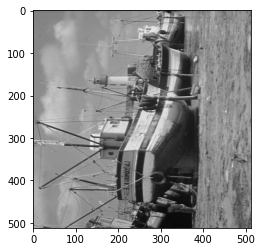

In [4]:
plt.imshow(img,cmap="gray")

In [9]:
print(len(cornerList))

7630
